In [1]:
import os
import sys
import glob
import h5py
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

### Dataset
First we download the dataset and caal it as 'data'

In [ ]:
#scarica il dataset modelnet40 usato nell'articolo DGCNN

!wget --no-check-certificate https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip
!unzip modelnet40_ply_hdf5_2048.zip
!mv modelnet40_ply_hdf5_2048 data/
!rm -f modelnet40_ply_hdf5_2048.zip

--2021-12-17 13:10:35--  https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 435212151 (415M) [application/zip]
Saving to: ‘modelnet40_ply_hdf5_2048.zip’

p                    32%[=====>              ] 133.27M   147KB/s    eta 19m 50s

Now we define utility functions to read data and labels and get data augmentation
>### Notes
>$glob$ is a built-in phyton mudole, it is a general term used to define techniques to match specified patterns according to rules related to Unix shell. More practical, it is used to retrieve files/pathnames matching a specified pattern. we can also use wildcards (*, ?, [ranges]) apart from exact string search to make path retrieval more simple.

>$os$ module in Python provides functions for interacting with the operating system. In particular $os.path$ module contains some useful functions on pathnames. The path parameters are either strings or bytes . These functions here are used for different purposes such as for merging, normalizing and retrieving path names in python. The method $os.path.join( , )$ has two arguments. The first is a path-like object representing a file system path, the second represents the path components to be joined. 

>$.h5$ is a format for scientific data. It contains multidimentional arrays

In [3]:
print(os.path.join('data',''))

data/


In [4]:
#legge dati e label
def load_data_cls(partition):#Used in class Dataset
    DATA_DIR = 'data'
    all_data = []
    all_label = []
    for h5_name in glob.glob(os.path.join(DATA_DIR,'*%s*.h5'%partition)):
        f = h5py.File(h5_name, 'r+')
        data = f['data'][:].astype('float32')
        label = f['label'][:].astype('int64')
        f.close()
        all_data.append(data)
        all_label.append(label)
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0)
    return all_data, all_label

In [5]:
# funzioni per dataugmentation (random traslation, rotations, jitter delle pointlcoud)
def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud

def rotate_pointcloud(pointcloud):
    theta = np.pi*2 * np.random.uniform()
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    pointcloud[:,[0,2]] = pointcloud[:,[0,2]].dot(rotation_matrix) # random rotation (x,z)
    return pointcloud

def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud

In [6]:
# classe per leggere il dataset e formattarlo in modo appopriato per l'input della DGCNN 
# il dataset contiene tre tipi di oggetti:
# points: la point cloud che contiene le coordinate dei punti: shape (N, P, C_p) N=numero esempi, P=numero punti per ogni esempio, C_p=numero feature associate a ciascun punto
# features: le feature associate ad ogni punto (possono essere le stesse coordinate o queste + ulteriori features): shape (N, P, C_f)
# mask: una mask che ha valore 1 o 0 per mascherare punti non fisici (quando P di un dato evento è inferiore alla dimensione con cui si e' fissato P): shape (N,P,1) 

class Dataset(object):
    def __init__(self, partition='train', num_points=1024): 
        self.data, self.label = load_data_cls(partition)
        self.partition = partition 
        self.num_points = num_points
        self._values = {}
        self._label = None
        self._load()
        
    def __len__(self):
        return len(self._label)

    def _load(self):
        pointcloud = self.data[:, :self.num_points, :]
        # per questo esempio tutti gli eventi hanno lo stesso numero di punti quindi la mask
        # e' una matrice di 1
        mask = np.ones(shape=(pointcloud.shape[0],pointcloud.shape[1],1)) 
        #if self.partition == 'train':
        #    pointcloud = translate_pointcloud(pointcloud)
        self._label = tf.keras.utils.to_categorical(self.label, num_classes=40)
        self._values['points'] = pointcloud
        self._values['features'] = pointcloud
        self._values['mask'] = mask
    
    def __getitem__(self, key):
        if key=='label':
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]  

Here we pratically build the trainand test datasets, and then we look at their shapes

In [7]:
#legge i dati di training e test
train = Dataset(partition='train', num_points=1024)
test = Dataset(partition='test', num_points=1024)

In [8]:
# mostra il contenuto dei dati
print(train['points'].shape)
print(test['points'].shape)
print(train['features'].shape)
print(test['features'].shape)
print(train['mask'].shape)
print(test['mask'].shape)

(9840, 1024, 3)
(2468, 1024, 3)
(9840, 1024, 3)
(2468, 1024, 3)
(9840, 1024, 1)
(2468, 1024, 1)


### Model
Here we buid our net.

>### Note
>The method $tf.nn.top_k(input, k, name=None)$ returns the largest k numbers of each line in input, and return the index of their location.

>The method $tf.tile(input, multiplies, name=None)$ creates a new tensor by replicating input multiples times. The output tensor's i'th dimension has input.dims(i) * multiples[i] elements, and the values of input are replicated multiples[i] times along the 'i'th dimension. For example, tiling [a b c d] by [2] produces [a b c d a b c d].

>The method $tf.gather_nd(params, indices, batch_dims=0, name=None)$  slices from params into a Tensor with shape specified by indices. Whereas in tf.gather(...) indices defines slices into the first dimension of params, in tf.gather_nd(...), indices defines slices into the first N dimensions of params, where N = indices.shape[-1].

> The $tf.squeeze(input, axis=None, name=None)$ method, given a tensor input, returns a tensor of the same type with all dimensions of size $1$ removed. If you don't want to remove all size $1$ dimensions, you can remove specific size $1$ dimensions by specifying axis.

>$pass$ it is a null statement that is commonly used as a placeholder ('segnaposto').

> $tf.keras.Input()$ is used to instantiate a Keras tensor. A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model. For instance, if $a$, $b$ and $c$ are Keras tensors, it becomes possible to do: $model = Model(input=[a, b], output=c)$

In [9]:
#DGCNN

# A shape is (N, P_A, C), B shape is (N, P_B, C)
# D shape is (N, P_A, P_B)
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):#It gives a name_scope at submitted operators, so 'r_A', when executed, will have name 'dmat/r_A'
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))#'Distance' between A and B
        return D
    
def knn(num_points, k, topk_indices, features): #k-nearest-neighbours
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    with tf.name_scope('knn'):
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1)) #(N, P, K, 1)
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2) indices ha, per ogni elemento, due numeri: il primo scala rispetto al batch
        return tf.gather_nd(features, indices)
    
def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='max', name='edgeconv'):
    """EdgeConv
    Args:
        num_points: number of points per event (1024)
        K: int, number of neighbors
        in_channels: # of input channels
        channels: tuple of output channels
        pooling: pooling method ('max' or 'average')
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Returns:
        transformed points: (N, P, C_out), C_out = channels[-1]
    """

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)  Becouse top_k returns the largest, using -D we get the smallest values
        indices = indices[:, :, 1:]  # (N, P, K); the 1: allow to esclude distance between each point to itself

        fts = features # (N, P, C)
        knn_fts = knn(num_points, K, indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C); copia le C K  volte
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C); abbiamo 2*C perche anniamo le C del centro e le C del vicino selezionato

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts


def _DGCNN_base(points, features=None, mask=None, setting=None, name='DGCNN_SG'): #it is used by get_DGCNN to build the net
    # points : (N, P, C_coord)
    # features:  (N, P, C_features), optional
    # mask: (N, P, 1), optional

    with tf.name_scope(name):
        if features is None:
            features = points
        
        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99   
            
        fts = tf.squeeze( keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)) , axis=2)

        for layer_idx, layer_param in enumerate(setting.conv_params):# Here creates the 4 edge_conv layers
            K, channels = layer_param
            pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))

        if mask is not None:
            fts = tf.multiply(fts, mask)

        pool = tf.reduce_mean(fts, axis=1)  # (N, C)

        if setting.fc_params is not None:#Here it creates the FC layers
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='softmax')(x)
            return out  # (N, num_classes)
        else:
            return pool


class _DotDict:
    pass

def get_DGCNN(num_classes, input_shapes):#Here we set all parameters of the net, its structure and then the _DGCNN_base really create it
    """
    Parameters
    ----------
    num_classes : int
        Number of output classes. Are classes that beongs to dataset, the ones we want train (e.g. ariplain, car,etc.)
    input_shapes : dict
        The shapes of each input (`points`, `features`, `mask`).
    """
    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3)); where c1, c2, c3 are MLP layers inside each edge conv, respectiveli...so at each edge coonv layer we can use dfferent numbers and lists
    setting.conv_params = [
        (20, (64, 64, 64)),  
        (20, (64, 64, 64)),
        (20, (128, 128, 128)),
        (20, (256, 256, 256)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [
        (512, 0.5),
        (256, 0.5),
        ]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _DGCNN_base(points, features, mask, setting, name='DGCNN_SG')

    print(type(points))
    print(type(features))
    
    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='DGCNN_SG')


In [10]:
num_classes = 40
input_shapes = {k:train[k].shape[1:] for k in train.X}
print(input_shapes)
model = get_DGCNN(num_classes, input_shapes)

{'points': (1024, 3), 'features': (1024, 3), 'mask': (1024, 1)}


2022-02-01 18:41:43.894712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22074 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


<class 'keras.engine.keras_tensor.KerasTensor'>
<class 'keras.engine.keras_tensor.KerasTensor'>


In [11]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2022-02-01 18:41:44,760] INFO: Learning rate: 0.001000


Model: "DGCNN_SG"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
tf.math.not_equal (TFOpLambda)  (None, 1024, 1)      0           mask[0][0]                       
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 1024, 1)      0           tf.math.not_equal[0][0]          
__________________________________________________________________________________________________
tf.math.equal (TFOpLambda)      (None, 1024, 1)      0           tf.cast[0][0]                    
___________________________________________________________________________________________

In [13]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'DGCNN_modelbest.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [14]:
# Training parameters
batch_size = 32
epochs = 5

In [15]:
train.shuffle()
model.fit(train.X, train.y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(test.X, test.y),
          shuffle=True,
          callbacks=callbacks)

2022-02-01 18:41:55.654631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
[2022-02-01 18:41:55,704] INFO: Learning rate: 0.001000


Epoch 1/5


2022-02-01 18:41:58.936601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300
2022-02-01 18:42:01.417308: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


      0/Unknown - 74s 0s/sample - loss: 2.3768 - accuracy: 0.3718
Epoch 00001: val_accuracy improved from -inf to 0.11062, saving model to model_checkpoints/DGCNN_modelbest.h5
308/308 [==============================] - 81s 264ms/sample - loss: 2.3768 - accuracy: 0.3718 - val_loss: 4.0636 - val_accuracy: 0.1106 - lr: 0.0010


[2022-02-01 18:43:16,964] INFO: Learning rate: 0.001000


Epoch 2/5
  0/308 [..............................] - ETA: 0s - loss: 1.6234 - accuracy: 0.5390
Epoch 00002: val_accuracy improved from 0.11062 to 0.53160, saving model to model_checkpoints/DGCNN_modelbest.h5
308/308 [==============================] - 68s 220ms/sample - loss: 1.6234 - accuracy: 0.5390 - val_loss: 1.5817 - val_accuracy: 0.5316 - lr: 0.0010


[2022-02-01 18:44:24,595] INFO: Learning rate: 0.001000


Epoch 3/5
  0/308 [..............................] - ETA: 0s - loss: 1.3483 - accuracy: 0.6051
Epoch 00003: val_accuracy did not improve from 0.53160
308/308 [==============================] - 67s 218ms/sample - loss: 1.3483 - accuracy: 0.6051 - val_loss: 1.9177 - val_accuracy: 0.4818 - lr: 0.0010


[2022-02-01 18:45:31,839] INFO: Learning rate: 0.001000


Epoch 4/5
  0/308 [..............................] - ETA: 0s - loss: 1.1594 - accuracy: 0.6574
Epoch 00004: val_accuracy improved from 0.53160 to 0.71840, saving model to model_checkpoints/DGCNN_modelbest.h5
308/308 [==============================] - 67s 219ms/sample - loss: 1.1594 - accuracy: 0.6574 - val_loss: 0.9700 - val_accuracy: 0.7184 - lr: 0.0010


[2022-02-01 18:46:39,254] INFO: Learning rate: 0.001000


Epoch 5/5
  0/308 [..............................] - ETA: 0s - loss: 1.0579 - accuracy: 0.6794
Epoch 00005: val_accuracy did not improve from 0.71840
308/308 [==============================] - 67s 217ms/sample - loss: 1.0579 - accuracy: 0.6794 - val_loss: 0.9402 - val_accuracy: 0.7046 - lr: 0.0010


In [24]:
model.load_weights("model_checkpoints/DGCNN_modelbest.h5")

In [25]:
test_loss, test_acc = model.evaluate(test.X, test.y, verbose=2)

78/78 - 6s - loss: 0.3906 - accuracy: 0.8861


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

pred = model.predict(test.X)
matrix = confusion_matrix(test.y.argmax(axis=1), pred.argmax(axis=1), normalize='true')

In [27]:
#confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [28]:
le_label=[ str(i) for i in range(test.y.shape[1])]
print_cm(matrix,le_label)

              0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39 
        0  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
        1  0.00  0.86  0.10  0.00  0.00  0.00  0.04  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 
        2  0.00  0.00  0.99  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.

In [29]:
mean_acc = 0
for i in range(len(matrix[0])):
    mean_acc += matrix[i][i]
mean_acc /= len(matrix[0])
print(mean_acc)

0.8229651162790697


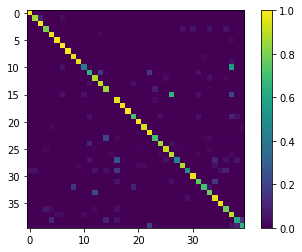

In [30]:
plt.imshow(matrix)
plt.colorbar()
plt.show()

## Here ends standard code

In [22]:
#TEST to study knn function
x = tf.reshape(tf.range(60), (-1, 1, 1, 1))# shape = (60, 1, 1, 1)
x = tf.tile(x, (1, 20, 10, 1))# shape = (60, 20, 10, 1)
x = tf.concat([x, x], axis=3)# shape = (60, 20, 10, 2)

fts = tf.reshape(tf.range(60), (-1, 1, 1))# shape = (60, 1, 1)
fts = tf.tile(fts, (1, 20, 20))# shape = (60, 20, 20)

fts = tf.gather_nd(fts, x)# shape = (60, 20, 10, 20)
print( fts )

tf.Tensor(
[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[1 1 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   ...
   [1 1 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]]

  [[1 1 1 ... 1 1 1]
   [1 1 1 ... 

In the algorithm in reality doesn't happen the conctenate step... the edge conv layers just follow each others, so we should change the 'for' of edge conv to allow to save output on each step and the concatenate all them togheter

In [23]:
setting_conv_params = [
    (20, (64, 64, 64)),  
    (20, (64, 64, 64)),
    (20, (128, 128, 128)),
    (20, (256, 256, 256)),
    ]

fts_dict = {}
for layer_idx, layer_param in enumerate(setting_conv_params):
    fts += fts
    #things that output our fps
    string = 'fts_%d' % (layer_idx)
    fts_dict[string]=fts
print(fts_dict)

fts =tf.concat([fts_dict['fts_0'], fts_dict['fts_1'], fts_dict['fts_2'], fts_dict['fts_3']], axis=-1)
print(fts.shape)
fts = keras.layers.Conv2D(60, kernel_size=(1, 1), strides=1)(fts)#60 will be 1024 in the algorithm... and so N
print(fts.shape)

{'fts_0': <tf.Tensor: shape=(60, 20, 10, 20), dtype=int32, numpy=
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
      

InvalidArgumentError: cannot compute Conv2D as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Conv2D]

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))